In [1]:
#Colab Setup
%tensorflow_version 2.x

from google.colab import drive
drive.mount('/content/gdrive')

!pip install pymorphy2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 7.1MB 26kB/s 


In [0]:
import sys
sys.path.append("/content/gdrive/My Drive/smu-ABAE/classes")

review_corpus_path = "/content/gdrive/My Drive/smu-ABAE/data/tech_review_sent_corpus.pkl"
vocab_path = "/content/gdrive/My Drive/smu-ABAE/data/vocab-text-review.txt"
emb_filename = '/content/gdrive/My Drive/smu-ABAE/models/w2v_embedding'
aspect_file_path = "/content/gdrive/My Drive/smu-ABAE/results/aspect.log"
aspect_model_path = '/content/gdrive/My Drive/smu-ABAE/results/model_param'


In [0]:
import sys
import os

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    sys.path.append(module_path+"/classes")

review_corpus_path = "../data/tech_review_sent_corpus.pkl"
vocab_path = "../data/glove-tech-revew-vocab.txt"
emb_filename = '../models/w2v_embedding'
aspect_file_path = "../results/aspect.log"
aspect_model_path = "../results/model_param"
vocab_path = "../data/vocab-text-review.txt"


In [4]:
import pandas as pd
import pickle

with open(review_corpus_path,"rb") as f:
    tech_review_corpus = pickle.load(f)

print(len(tech_review_corpus))
display(pd.DataFrame(tech_review_corpus).head(10))

reviews = pd.DataFrame(tech_review_corpus).review.tolist()

156991


,index,review
0,299,great company people care make difference
1,299,management care employee well providing contin...
2,1145,powerhouse epc went heavy worksharing
3,1145,send much work overseas possible keep core person
4,1145,heavy loaded company management
5,1145,chase project hire thousand oil booming
6,1145,turn lay thousand going
7,1145,sharpest spike hiring laying
8,1145,employee clearly greatest asset
9,1375,much could add


In [0]:
## Parmeters

In [6]:
import ABAE.utils as U
parser = U.add_common_args()

#Paramaters
maxlen = 115 #Based on 2 standard deviations from mean
algorithm = "adam"
neg_size = 20
emb_dim = 300
aspect_size = 8
ortho_reg_default = 0.1
batch_size = 32
epochs = 15

Using TensorFlow backend.


## Setup Data

Max Character length 1284
Average Character Length 44.00466268766999
Standard Deviation 35.8821138064807
Median Character Length 36.0
Characters 2 standard deviations from mean 115.7688903006314


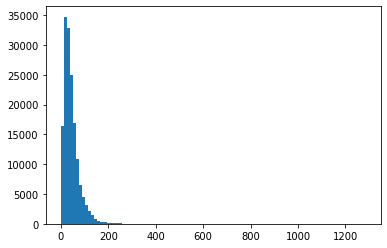

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
word_length = pd.DataFrame(tech_review_corpus).review.apply(len).tolist()

print("Max Character length", max(word_length))
print("Average Character Length", np.mean(word_length))
print("Standard Deviation", np.std(word_length))
print("Median Character Length", np.median(word_length))
print("Characters 2 standard deviations from mean", np.mean(word_length) + (2*np.std(word_length)))

plt.hist(word_length,bins=100)
plt.show()

In [14]:
import importlib

importlib.reload(dataset)

<module 'ABAE.reader' from '/content/gdrive/My Drive/smu-ABAE/classes/ABAE/reader.py'>

In [16]:
from keras.preprocessing import sequence
import ABAE.reader as dataset

vocab, train_x, overall_maxlen = dataset.get_data(reviews, vocab_path, vocab_size=0, maxlen=maxlen)
train_x = sequence.pad_sequences(train_x, maxlen=overall_maxlen)

vocab_inv = {}
for w, ind in vocab.items():
    vocab_inv[ind] = w
    
# train_x = train_x[0:30000]
print('Number of training examples: ', len(train_x))
print('Length of vocab: ', len(vocab))

 Creating vocab ...
   966463 total words, 23229 unique words
 Reading dataset ...
  train set
   <num> hit rate: 1.21%, <unk> hit rate: 0.00%
Number of training examples:  148531
Length of vocab:  23232


In [17]:
print("Validate index to word")
print( [vocab_inv[i] for i in train_x[2] ] )
print("\n")
print( [vocab_inv[i] for i in train_x[0] ] )

Validate index to word
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

## Attention-Based-Aspect-Detection Code

In [0]:
# import importlib
# import ABAE.optimizers
# importlib.reload(ABAE.optimizers)

In [19]:
import keras.optimizers as opt

def sentence_batch_generator(data, batch_size):
    n_batch = len(data) // batch_size
    batch_count = 0
    np.random.shuffle(data)

    while True:
        if batch_count == n_batch:
            np.random.shuffle(data)
            batch_count = 0

        batch = data[batch_count * batch_size: (batch_count + 1) * batch_size]
        batch_count += 1
        yield batch


def negative_batch_generator(data, batch_size, neg_size):
    data_len = data.shape[0]
    dim = data.shape[1]

    while True:
        indices = np.random.choice(data_len, batch_size * neg_size)
        samples = data[indices].reshape(batch_size, neg_size, dim)
        yield samples

def get_optimizer(algo = "adam"):
    clipvalue = 0
    clipnorm = 10

    if algo == 'rmsprop':
        return opt.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06, clipnorm=clipnorm, clipvalue=clipvalue)
    elif algo == 'sgd':
        return opt.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False, clipnorm=clipnorm, clipvalue=clipvalue)
    elif algo == 'adagrad':
        return opt.Adagrad(lr=0.01, epsilon=1e-06, clipnorm=clipnorm, clipvalue=clipvalue)
    elif algo == 'adadelta':
        return opt.Adadelta(lr=1.0, rho=0.95, epsilon=1e-06, clipnorm=clipnorm, clipvalue=clipvalue)
    elif algo == 'adam':
        return opt.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, clipnorm=clipnorm, clipvalue=clipvalue)
    elif algo == 'adamax':
        return opt.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, clipnorm=clipnorm, clipvalue=clipvalue)

optimizer = get_optimizer(algorithm)
print(optimizer)

In [0]:
# import importlib
# import ABAE.w2vEmbReader
# importlib.reload(ABAE.w2vEmbReader)

Create Word Embedding and Aspect Embeddings

In [20]:
import importlib
import ABAE.w2vEmbReader
importlib.reload(ABAE.w2vEmbReader)

<module 'ABAE.w2vEmbReader' from '/content/gdrive/My Drive/smu-ABAE/classes/ABAE/w2vEmbReader.py'>

In [21]:
import logging
import os
import keras.backend as K
from keras.layers import Dense, Activation, Embedding, Input
from keras.models import Model
from keras.constraints import MaxNorm

from ABAE.my_layers import Attention, Average, WeightedSum, WeightedAspectEmb, MaxMargin
from ABAE.w2vEmbReader import W2VEmbReader as EmbReader

def create_model(overall_maxlen, vocab, aspect_size):
    def ortho_reg(weight_matrix):
        ### orthogonal regularization for aspect embedding matrix ###
        w_n = K.l2_normalize(weight_matrix, axis=-1)
        reg = K.sum(K.square(K.dot(w_n, K.transpose(w_n)) - K.eye(w_n.shape[0])))
        return ortho_reg_default * reg
    
    
    # ##### Inputs #####
    sentence_input = Input(shape=(overall_maxlen,), dtype='int32', name='sentence_input')
    neg_input = Input(shape=(neg_size, overall_maxlen), dtype='int32', name='neg_input')

    vocab_size = len(vocab)
    
    emb_reader = EmbReader(emb_filename)

    aspect_matrix = emb_reader.get_aspect_matrix(aspect_size)
    aspect_size = emb_reader.aspect_size
    emb_dim = emb_reader.emb_dim
    
    # ##### Construct word embedding layer #####
    word_emb = Embedding(vocab_size, emb_dim,
                         mask_zero=True, name='word_emb',
                         embeddings_constraint=MaxNorm(10))

    ##### Compute sentence representation #####
    e_w = word_emb(sentence_input)
    y_s = Average()(e_w)
    att_weights = Attention(name='att_weights',
                            W_constraint=MaxNorm(10),
                            b_constraint=MaxNorm(10))([e_w, y_s])
    z_s = WeightedSum()([e_w, att_weights])

    ##### Compute representations of negative instances #####
    e_neg = word_emb(neg_input)
    z_n = Average()(e_neg)

    ##### Reconstruction #####
    p_t = Dense(aspect_size)(z_s)
    p_t = Activation('softmax', name='p_t')(p_t)
    r_s = WeightedAspectEmb(aspect_size, emb_dim, name='aspect_emb',
                            W_constraint=MaxNorm(10),
                            W_regularizer=ortho_reg)(p_t)

    ##### Loss #####
    loss = MaxMargin(name='max_margin')([z_s, z_n, r_s])
    model = Model(inputs=[sentence_input, neg_input], outputs=[loss])

    ### Word embedding and aspect embedding initialization ######
    print('Initializing word embedding matrix')
    embs = model.get_layer('word_emb').embeddings
    K.set_value(embs, emb_reader.get_emb_matrix_given_vocab(vocab, K.get_value(embs)))
    print('Initializing aspect embedding matrix as centroid of kmean clusters')
    K.set_value(model.get_layer('aspect_emb').W, aspect_matrix)

    return model
    
model = create_model(overall_maxlen, vocab, aspect_size)
# freeze the word embedding layer
model.get_layer('word_emb').trainable = False
model.compile(optimizer=optimizer, loss=U.max_margin_loss, metrics=[U.max_margin_loss])

print(model.summary())

2020-05-21 01:09:40,597 INFO Loading embeddings from: /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding
2020-05-21 01:09:40,598 INFO loading Word2VecKeyedVectors object from /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-05-21 01:09:42,705 INFO loading wv recursively from /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding.wv.* with mmap=None
2020-05-21 01:09:42,706 INFO setting ignored attribute vectors_norm to None
2020-05-21 01:09:42,708 INFO loading vocabulary recursively from /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding.vocabulary.* with mmap=None
2020-05-21 01:09:42,709 INFO loading trainables recursiv

  #vectors: 44788, #dimensions: 200
Initializing word embedding matrix
18266/23232 word vectors initialized (hit rate: 78.62%)
Initializing aspect embedding matrix as centroid of kmean clusters
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_input (InputLayer)     (None, 115)          0                                            
__________________________________________________________________________________________________
word_emb (Embedding)            multiple             4646400     sentence_input[0][0]             
                                                                 neg_input[0][0]                  
__________________________________________________________________________________________________
average_1 (Average)             (None, 200)          0           word_emb[0][0]                 

In [31]:
import logging
import numpy as np
from time import time

logging.basicConfig(
    # filename='out.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger(__name__)

from tqdm import tqdm

logger.info("-"*80)
    
sen_gen = sentence_batch_generator(train_x, batch_size)
neg_gen = negative_batch_generator(train_x, batch_size, neg_size)
batches_per_epoch = len(train_x) // batch_size

min_loss = float('inf')
for ii in range(epochs):
    t0 = time()
    loss, max_margin_loss = 0., 0.

    for b in tqdm(range(batches_per_epoch)):
        sen_input = next(sen_gen)
        neg_input = next(neg_gen)

        batch_loss, batch_max_margin_loss = model.train_on_batch([sen_input, neg_input],
                                                                 np.ones((batch_size, 1)))
        loss += batch_loss / batches_per_epoch
        max_margin_loss += batch_max_margin_loss / batches_per_epoch

    tr_time = time() - t0

    if loss < min_loss:
        min_loss = loss
        word_emb = K.get_value(model.get_layer('word_emb').embeddings)
        aspect_emb = K.get_value(model.get_layer('aspect_emb').W)
        word_emb = word_emb / np.linalg.norm(word_emb, axis=-1, keepdims=True)
        aspect_emb = aspect_emb / np.linalg.norm(aspect_emb, axis=-1, keepdims=True)
        aspect_file = open(aspect_file_path, 'wt', encoding='utf-8')
        model.save(aspect_model_path)
        
        for ind in range(len(aspect_emb)):
            desc = aspect_emb[ind]
            sims = word_emb.dot(desc.T)
            ordered_words = np.argsort(sims)[::-1]
            desc_list = [vocab_inv[w] + "|" + str(sims[w]) for w in ordered_words[:100]]
            print('Aspect %d:' % ind)
            print(desc_list)
            aspect_file.write('Aspect %d:\n' % ind)
            aspect_file.write(' '.join(desc_list) + '\n\n')

    print('Epoch %d, train: %is' % (ii, tr_time))
    print('Total loss: %.4f, max_margin_loss: %.4f, ortho_reg: %.4f' % (loss, max_margin_loss, loss - max_margin_loss))
    

2020-05-21 01:17:58,746 INFO --------------------------------------------------------------------------------
  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.63931644', 'inc|0.59631544', 'semiconductor|0.5880024', 'telecommunication|0.5831719', 'industry|0.57256913', 'ai|0.5671143', 'plc|0.5668682', 'ecosystem|0.56495196', 'ml|0.5631658', 'veatch|0.5621454', 'mining|0.5586677', 'ag|0.55629647', 'robotics|0.55453', 'manufacture|0.55086017', 'virtualization|0.55052006', 'ecommerce|0.54948056', 'platform|0.5489116', 'iot|0.54880697', 'corporation|0.5459807', 'modelling|0.54377306', 'catia|0.5431661', 'era|0.5419843', 'retailing|0.54079795', 'enterprise|0.54015934', 'solar|0.53952914', 'powerhouse|0.53940177', 'arena|0.53932595', 'telematics|0.5371491', 'formerly|0.5356269', 'mb|0.5354877', 'llc|0.5331216', 'chrysler|0.5323968', 'infotainment|0.53038716', 'division|0.5289086', 'telecom|0.5269057', 'manufacturer|0.52682805', 'gateway|0.52651495', 'diagnostics|0.5254923', 'v5|0.5207591', 'oem|0.51982147', 'hana|0.51973486', 'analytics|0.51959556', 'aftermarket|0.51946104', 'subdivision|0.51708865', 'revolution|0.5167513', 'orga

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.6277182', 'inc|0.5841716', 'industry|0.57765543', 'telecommunication|0.5762893', 'semiconductor|0.5738214', 'ai|0.55772823', 'ecosystem|0.5571724', 'veatch|0.5522758', 'plc|0.5515695', 'ml|0.55028987', 'mining|0.5488463', 'corporation|0.54620075', 'platform|0.5445943', 'ag|0.5434779', 'robotics|0.5413531', 'manufacture|0.5413055', 'ecommerce|0.5396841', 'iot|0.53916794', 'retailing|0.5376488', 'arena|0.53528094', 'virtualization|0.53402925', 'modelling|0.533812', 'era|0.53374887', 'powerhouse|0.5316194', 'enterprise|0.5311836', 'solar|0.5295135', 'catia|0.5253273', 'telematics|0.5233501', 'organization|0.5227845', 'chrysler|0.5223512', 'company|0.52219677', 'llc|0.5192421', 'mb|0.5191046', 'manufacturer|0.5186398', 'telecom|0.5163078', 'division|0.5160859', 'formerly|0.516065', 'infotainment|0.51530486', 'diagnostics|0.51367766', 'analytics|0.51266384', 'aftermarket|0.51176286', 'gateway|0.5109526', 'transforms|0.50960934', 'revolution|0.50871557', 'oem|0.50554764', 

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.62045884', 'inc|0.58904177', 'telecommunication|0.57861626', 'industry|0.5777378', 'semiconductor|0.56945', 'veatch|0.5553174', 'ai|0.55179405', 'ecosystem|0.55066895', 'ml|0.54848045', 'plc|0.5472436', 'ag|0.54445934', 'platform|0.54195225', 'corporation|0.54176235', 'mining|0.5376294', 'robotics|0.5362253', 'retailing|0.53616726', 'ecommerce|0.5360328', 'manufacture|0.5350497', 'iot|0.5346259', 'arena|0.5338855', 'powerhouse|0.52907157', 'virtualization|0.5286065', 'enterprise|0.52731216', 'solar|0.5265623', 'era|0.5264673', 'chrysler|0.52566946', 'company|0.52278316', 'llc|0.5213923', 'modelling|0.52130413', 'catia|0.52063483', 'organization|0.518697', 'formerly|0.51666296', 'mb|0.5152556', 'telecom|0.51474905', 'telematics|0.5147299', 'diagnostics|0.51254874', 'manufacturer|0.51090693', 'division|0.5102263', 'infotainment|0.508812', 'aftermarket|0.5071238', 'gateway|0.5065458', 'transforms|0.5058985', 'venture|0.5045271', 'analytics|0.5044084', 'revolution|0.5024

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.6193097', 'inc|0.58781236', 'industry|0.5804768', 'telecommunication|0.57922065', 'semiconductor|0.5770763', 'veatch|0.5622957', 'ai|0.5583099', 'ecosystem|0.5510605', 'ml|0.5506203', 'plc|0.54851246', 'ag|0.54596883', 'corporation|0.54571116', 'iot|0.54156303', 'robotics|0.5409992', 'retailing|0.5372914', 'platform|0.53715235', 'mining|0.5355914', 'ecommerce|0.53504676', 'powerhouse|0.53226435', 'arena|0.5319519', 'manufacture|0.5313427', 'virtualization|0.529887', 'era|0.52935296', 'company|0.52852166', 'chrysler|0.52805275', 'catia|0.5236788', 'solar|0.52290463', 'enterprise|0.52152157', 'modelling|0.52122724', 'organization|0.52011186', 'llc|0.5195983', 'telecom|0.5169982', 'formerly|0.51634836', 'telematics|0.5156059', 'transforms|0.50960433', 'diagnostics|0.50867206', 'infotainment|0.50854015', 'mb|0.5077865', 'analytics|0.5058294', 'division|0.5050492', 'venture|0.50496083', 'delphi|0.50393856', 'aftermarket|0.5024668', 'revolution|0.5020114', 'cybersecurity|0

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.61366284', 'industry|0.58051336', 'inc|0.5793358', 'telecommunication|0.576278', 'semiconductor|0.57608366', 'veatch|0.5639269', 'ai|0.55692625', 'ecosystem|0.5506484', 'corporation|0.5488292', 'arena|0.54433566', 'ml|0.5435868', 'iot|0.5416727', 'retailing|0.5405087', 'robotics|0.5384839', 'ag|0.5384582', 'powerhouse|0.53591144', 'era|0.5347703', 'plc|0.5329542', 'chrysler|0.53165305', 'manufacture|0.52826166', 'mining|0.52778244', 'ecommerce|0.52775633', 'organization|0.52512544', 'company|0.5250857', 'catia|0.52411675', 'virtualization|0.5237764', 'platform|0.5227194', 'modelling|0.51879597', 'venture|0.51669747', 'enterprise|0.5149771', 'transforms|0.51388216', 'solar|0.5138159', 'llc|0.5132152', 'telematics|0.5113764', 'telecom|0.50943345', 'formerly|0.5091691', 'revolution|0.5080887', 'predix|0.5056325', 'cybersecurity|0.5046989', 'delphi|0.50439537', 'computing|0.5041399', 'sector|0.5040308', 'infotainment|0.5012764', 'broadcom|0.5010763', 'acquired|0.4992026'

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.6084038', 'industry|0.581054', 'telecommunication|0.57880425', 'inc|0.57730955', 'semiconductor|0.57300776', 'veatch|0.56447804', 'ai|0.55421174', 'corporation|0.5482871', 'ecosystem|0.5437926', 'ml|0.54298806', 'arena|0.54087055', 'retailing|0.54014623', 'iot|0.5382935', 'ag|0.53778315', 'robotics|0.53530467', 'powerhouse|0.53482544', 'chrysler|0.53456175', 'era|0.52909124', 'plc|0.528202', 'company|0.5280514', 'ecommerce|0.5250798', 'organization|0.5240836', 'catia|0.5237031', 'manufacture|0.5234543', 'mining|0.52167875', 'virtualization|0.51898897', 'platform|0.5163968', 'modelling|0.5132613', 'venture|0.51288736', 'llc|0.5108905', 'enterprise|0.51027536', 'telecom|0.50985897', 'transforms|0.5098178', 'formerly|0.50839835', 'solar|0.50748', 'telematics|0.506611', 'delphi|0.5062292', 'computing|0.5038668', 'acquired|0.5032676', 'revolution|0.5029872', 'cybersecurity|0.5022291', 'sector|0.5015464', 'predix|0.50152147', 'broadcom|0.49904814', 'mellon|0.4982817', 'dia

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.6089064', 'inc|0.5808366', 'telecommunication|0.58032835', 'industry|0.5774861', 'semiconductor|0.5734919', 'veatch|0.57302463', 'ai|0.5541343', 'corporation|0.55004704', 'ml|0.54639614', 'ecosystem|0.546138', 'ag|0.544782', 'iot|0.5411315', 'arena|0.54077065', 'retailing|0.53955764', 'chrysler|0.5385091', 'powerhouse|0.5376694', 'robotics|0.5346983', 'company|0.5329289', 'plc|0.5322072', 'ecommerce|0.528767', 'catia|0.5284598', 'era|0.5279974', 'organization|0.5264561', 'virtualization|0.5222058', 'platform|0.5220158', 'manufacture|0.5211788', 'mining|0.52026623', 'llc|0.5159298', 'venture|0.5144226', 'modelling|0.5143618', 'telecom|0.513355', 'formerly|0.512686', 'enterprise|0.51264703', 'telematics|0.5099224', 'transforms|0.50968266', 'delphi|0.50920576', 'computing|0.5068027', 'mellon|0.5057101', 'acquired|0.50556976', 'cybersecurity|0.5051349', 'solar|0.50414026', 'broadcom|0.5036221', 'foundation|0.5032984', 'diagnostics|0.50299335', 'predix|0.5027122', 'packar

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.6097348', 'inc|0.583159', 'telecommunication|0.5801691', 'industry|0.5787916', 'semiconductor|0.57403654', 'veatch|0.5738056', 'ai|0.5553845', 'ml|0.553444', 'ag|0.54988384', 'corporation|0.5494144', 'ecosystem|0.5456849', 'chrysler|0.5423136', 'retailing|0.54196364', 'iot|0.5418016', 'powerhouse|0.5391302', 'arena|0.53829116', 'company|0.5362414', 'robotics|0.5346707', 'era|0.53237957', 'plc|0.5316496', 'ecommerce|0.52978206', 'catia|0.5282402', 'manufacture|0.52277946', 'organization|0.52225876', 'virtualization|0.52142894', 'platform|0.52058494', 'mining|0.51916903', 'llc|0.51884997', 'venture|0.51815736', 'formerly|0.5166575', 'telecom|0.51552266', 'enterprise|0.5138271', 'modelling|0.51372194', 'delphi|0.5109357', 'telematics|0.5089663', 'mellon|0.5088085', 'broadcom|0.5077654', 'acquired|0.50739235', 'computing|0.5071287', 'transforms|0.5070611', 'cybersecurity|0.50632346', 'solar|0.5055807', 'symantec|0.5049511', 'sector|0.5045916', 'diagnostics|0.5041945', 'f

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.6060116', 'telecommunication|0.5809608', 'inc|0.5800867', 'industry|0.57809955', 'veatch|0.5733204', 'semiconductor|0.57327175', 'ai|0.55263436', 'corporation|0.5525341', 'ml|0.55138683', 'ag|0.54908437', 'chrysler|0.5435728', 'retailing|0.5428066', 'company|0.5399651', 'ecosystem|0.5398943', 'iot|0.5389682', 'powerhouse|0.5379012', 'arena|0.53482836', 'robotics|0.5335439', 'plc|0.5324845', 'catia|0.5286154', 'era|0.52860206', 'ecommerce|0.5282899', 'manufacture|0.5223708', 'organization|0.5217983', 'virtualization|0.519895', 'llc|0.51925695', 'platform|0.5191414', 'mining|0.5178751', 'telecom|0.5169436', 'venture|0.5135634', 'formerly|0.51304746', 'enterprise|0.51075876', 'delphi|0.50988775', 'modelling|0.509602', 'telematics|0.50821364', 'mellon|0.50705934', 'diagnostics|0.50606596', 'acquired|0.5053409', 'computing|0.5051337', 'cybersecurity|0.50505966', 'sector|0.50444496', 'transforms|0.50401413', 'symantec|0.5037919', 'solar|0.5037866', 'titan|0.50348544', 'bro

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.60667396', 'telecommunication|0.58208597', 'inc|0.5807431', 'industry|0.5788654', 'veatch|0.57525945', 'semiconductor|0.57421637', 'ml|0.55372345', 'corporation|0.55304', 'ai|0.55222', 'ag|0.55085874', 'chrysler|0.5473342', 'retailing|0.5456209', 'company|0.54454136', 'iot|0.53966916', 'powerhouse|0.53856707', 'ecosystem|0.53852683', 'arena|0.5340719', 'plc|0.53302914', 'robotics|0.5328975', 'catia|0.5293037', 'ecommerce|0.52898324', 'era|0.5283426', 'organization|0.5222571', 'manufacture|0.5208989', 'virtualization|0.5202967', 'llc|0.5190036', 'telecom|0.51849204', 'platform|0.5173904', 'formerly|0.51642203', 'mining|0.51620036', 'delphi|0.5136826', 'venture|0.512531', 'enterprise|0.51148707', 'mellon|0.50914145', 'modelling|0.5088159', 'acquired|0.50853544', 'telematics|0.50793606', 'symantec|0.50660205', 'diagnostics|0.5062637', 'broadcom|0.50562924', 'computing|0.5051592', 'packard|0.50514686', 'vw|0.5048581', 'cybersecurity|0.50479776', 'titan|0.50440896', 'sect

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.60520196', 'telecommunication|0.58290195', 'industry|0.58040404', 'inc|0.5760772', 'semiconductor|0.57456136', 'veatch|0.57377726', 'ml|0.5535058', 'ai|0.552673', 'corporation|0.55156314', 'ag|0.54980475', 'company|0.54810476', 'retailing|0.5456823', 'chrysler|0.5452457', 'iot|0.5396389', 'robotics|0.5358443', 'powerhouse|0.5355804', 'plc|0.5355114', 'ecosystem|0.5350983', 'arena|0.5315219', 'ecommerce|0.52987516', 'catia|0.52973306', 'era|0.5289643', 'virtualization|0.5220183', 'platform|0.5211381', 'telecom|0.5209591', 'manufacture|0.52053434', 'organization|0.519293', 'llc|0.51682615', 'mining|0.51597226', 'formerly|0.5117711', 'delphi|0.51050496', 'enterprise|0.5100764', 'acquired|0.5096563', 'modelling|0.50933194', 'venture|0.5092222', 'diagnostics|0.50738126', 'telematics|0.5071257', 'sector|0.50683373', 'symantec|0.5067139', 'mellon|0.5056484', 'cybersecurity|0.505537', 'computing|0.5048568', 'titan|0.5044472', 'broadcom|0.5027586', 'vw|0.50265026', 'solar|0.5

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.60343236', 'telecommunication|0.58338976', 'industry|0.580666', 'inc|0.57673585', 'veatch|0.5762956', 'semiconductor|0.5739793', 'ml|0.55431664', 'ai|0.5536085', 'company|0.5508785', 'ag|0.55057025', 'corporation|0.5501006', 'chrysler|0.54666746', 'retailing|0.545207', 'iot|0.53994477', 'plc|0.53852797', 'robotics|0.5372068', 'powerhouse|0.53515816', 'ecosystem|0.53477013', 'arena|0.53139675', 'ecommerce|0.5307197', 'catia|0.5300221', 'era|0.5263014', 'virtualization|0.52229494', 'manufacture|0.52203286', 'platform|0.52173007', 'organization|0.5213122', 'telecom|0.520586', 'mining|0.5176594', 'llc|0.517146', 'formerly|0.5108949', 'venture|0.5105652', 'diagnostics|0.5103218', 'delphi|0.5100702', 'enterprise|0.50962454', 'modelling|0.50922984', 'telematics|0.5080192', 'acquired|0.50799716', 'symantec|0.5066242', 'cybersecurity|0.50574356', 'mellon|0.50568855', 'sector|0.50555503', 'vw|0.5042172', 'titan|0.5041545', 'solar|0.5038083', 'computing|0.5033703', 'andersen|0.

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.60436803', 'industry|0.5850805', 'telecommunication|0.58504397', 'semiconductor|0.57432276', 'veatch|0.5736295', 'inc|0.56915486', 'company|0.55739903', 'ai|0.5557128', 'corporation|0.55445594', 'ml|0.5536593', 'ag|0.54864717', 'retailing|0.54834425', 'chrysler|0.54263496', 'iot|0.5423045', 'plc|0.5400577', 'robotics|0.53798705', 'powerhouse|0.5353167', 'ecosystem|0.53418136', 'ecommerce|0.5316547', 'era|0.5288689', 'arena|0.5280125', 'catia|0.52773345', 'virtualization|0.52397156', 'telecom|0.52391374', 'organization|0.52362204', 'platform|0.5226706', 'manufacture|0.52115124', 'mining|0.5191381', 'llc|0.512794', 'enterprise|0.5100925', 'sector|0.5089061', 'telematics|0.50857735', 'modelling|0.5084039', 'diagnostics|0.5083413', 'cybersecurity|0.507674', 'symantec|0.50686353', 'delphi|0.5066888', 'venture|0.5061953', 'acquired|0.5061213', 'formerly|0.50584406', 'computing|0.50437', 'titan|0.50383806', 'mellon|0.5026655', 'solar|0.501968', 'vw|0.5019547', 'feild|0.4988

  0%|          | 0/4641 [00:00<?, ?it/s]

Aspect 0:
['saas|0.60159814', 'industry|0.5856762', 'telecommunication|0.58339596', 'semiconductor|0.570745', 'veatch|0.5706475', 'inc|0.566223', 'company|0.563367', 'ai|0.5554317', 'ml|0.5533521', 'corporation|0.5533033', 'retailing|0.54717827', 'ag|0.546669', 'chrysler|0.54054826', 'iot|0.54045033', 'plc|0.53893375', 'robotics|0.53669286', 'ecommerce|0.532022', 'powerhouse|0.5312911', 'ecosystem|0.5306717', 'era|0.52741146', 'arena|0.526088', 'organization|0.5250646', 'catia|0.52323765', 'platform|0.5224913', 'telecom|0.5224446', 'virtualization|0.52166027', 'manufacture|0.5199008', 'mining|0.5167825', 'llc|0.5105139', 'enterprise|0.5090289', 'sector|0.5080621', 'telematics|0.5071902', 'venture|0.5069199', 'cybersecurity|0.50636524', 'diagnostics|0.5063129', 'modelling|0.5053156', 'symantec|0.50409853', 'acquired|0.50354517', 'delphi|0.50216794', 'feild|0.5015474', 'formerly|0.5014724', 'computing|0.50124615', 'solar|0.5011387', 'vw|0.5003193', 'titan|0.50006557', 'mellon|0.49958304'

100%|██████████| 4641/4641 [00:30<00:00, 150.57it/s]


Aspect 0:
['saas|0.59894335', 'industry|0.5840752', 'telecommunication|0.57998693', 'semiconductor|0.5698048', 'veatch|0.5696204', 'company|0.5665153', 'inc|0.56001985', 'ai|0.5571717', 'corporation|0.55256593', 'ml|0.55010605', 'retailing|0.54773664', 'ag|0.5427097', 'iot|0.54150563', 'plc|0.54098743', 'robotics|0.53859526', 'chrysler|0.53593224', 'ecommerce|0.5306761', 'ecosystem|0.5284801', 'powerhouse|0.52748054', 'era|0.52566177', 'platform|0.52513087', 'catia|0.52370954', 'organization|0.5235519', 'arena|0.5231288', 'virtualization|0.52158564', 'manufacture|0.51877147', 'telecom|0.5183914', 'mining|0.5177466', 'sector|0.5068305', 'enterprise|0.5057464', 'cybersecurity|0.5057072', 'modelling|0.5056813', 'telematics|0.5056572', 'llc|0.5052968', 'diagnostics|0.5045467', 'venture|0.5027908', 'symantec|0.5022797', 'acquired|0.5021361', 'feild|0.5010989', 'computing|0.5008049', 'analytics|0.5003873', 'solar|0.49919838', 'titan|0.49803317', 'delphi|0.4976924', 'vw|0.4968386', 'mellon|0.